<p>The dataset contains information about the number of passengers on international flights starting with January 1949 until December 1960. 

As you probably have guessed you will be trying to predict the number of passengers on international flights with a one-step forecast.


In [2]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from statsmodels.tsa.stattools import adfuller

import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

1. For comparable results set the random seed in both numpy and tensorflow to (123). You can use this code:

In [3]:
# setting same pseudo random gen's
np.random.seed(123)
tf.random.set_seed(123)

4. Create your data frame. To ensure that all works fine index the ‘Month’ column and parse the dates.

In [4]:
# load csv
passengers_df = pd.read_csv(os.getcwd() + '\\airline_passengers.csv')
passengers_df
for record in passengers_df.Month:
    print(record)
# honestly, no clue what this part should have done. I mean, I see the data range

1949-01
1949-02
1949-03
1949-04
1949-05
1949-06
1949-07
1949-08
1949-09
1949-10
1949-11
1949-12
1950-01
1950-02
1950-03
1950-04
1950-05
1950-06
1950-07
1950-08
1950-09
1950-10
1950-11
1950-12
1951-01
1951-02
1951-03
1951-04
1951-05
1951-06
1951-07
1951-08
1951-09
1951-10
1951-11
1951-12
1952-01
1952-02
1952-03
1952-04
1952-05
1952-06
1952-07
1952-08
1952-09
1952-10
1952-11
1952-12
1953-01
1953-02
1953-03
1953-04
1953-05
1953-06
1953-07
1953-08
1953-09
1953-10
1953-11
1953-12
1954-01
1954-02
1954-03
1954-04
1954-05
1954-06
1954-07
1954-08
1954-09
1954-10
1954-11
1954-12
1955-01
1955-02
1955-03
1955-04
1955-05
1955-06
1955-07
1955-08
1955-09
1955-10
1955-11
1955-12
1956-01
1956-02
1956-03
1956-04
1956-05
1956-06
1956-07
1956-08
1956-09
1956-10
1956-11
1956-12
1957-01
1957-02
1957-03
1957-04
1957-05
1957-06
1957-07
1957-08
1957-09
1957-10
1957-11
1957-12
1958-01
1958-02
1958-03
1958-04
1958-05
1958-06
1958-07
1958-08
1958-09
1958-10
1958-11
1958-12
1959-01
1959-02
1959-03
1959-04
1959-05


5. Plot the data and check for stationarity. You can use the Dickey Fuller test to do this. Or if you would rather rely just on visual inspection, argument your conclusion on whether data are stationary or not. Remember, for stationarity you will want a constant variance (i.e. variance is not increasing/decreasing with time) and no trend in your data. If data proved to be non-stationary correct for this problem. (to correct for variance issues you can log transform the data, for trend, you can take the first difference).

ADF Statistic: 0.815369
p-value: 0.991880
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579
Failed to Reject Ho - Time Series is Non-Stationary


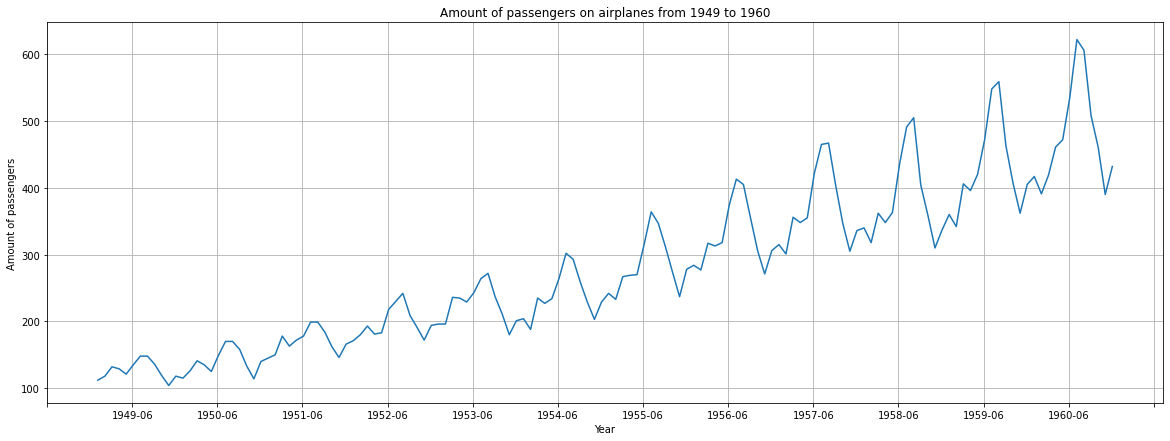

In [5]:

# ADF Test
result = adfuller(passengers_df.Passengers.values, autolag='AIC')
# print(f"Dickey-Fuller testy result: {result[0]}")
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
# (link to source: https://analyticsindiamag.com/complete-guide-to-dickey-fuller-test-in-time-series-analysis/?fbclid=IwAR0_9LMa9MZzlJkLbjN6RC669pqJU8apxj4TUSy938AhNnp19r0X28FWMCM)



fig, ax = plt.subplots(figsize=(20, 7))
year_range = [int(str(x).split('-')[0]) for x in passengers_df.Month]


ax.plot(passengers_df.Month, passengers_df.Passengers)
ax.set_title("Amount of passengers on airplanes from 1949 to 1960")
ax.set_xlabel("Year")
ax.set_ylabel("Amount of passengers")
ax.grid(True)
plt.xticks(np.arange(min(year_range), max(year_range), 12.0))
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 12))
plt.show()

Plotting by month looks to messy on the bottom, so I decided to go by year. With grid 'on' we can see that the behavior is cyclic, it repeats every year and we can see max value of passengers at about July, when everybody goes on vacation. Also the overall amount of airplane passengers grow every year. So both by dickey-fuller and visually we can conclude that this dataset is not stationary.

Then.. we make it stationary by... 'for trend, you can take the first difference'. k.

C:\Users\mpaka\AppData\Local\Temp\ipykernel_14728\1715124428.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passengers_df["Untrended Passengers"][0] = int(passengers_df["Untrended Passengers"].mean())


-101 : 87


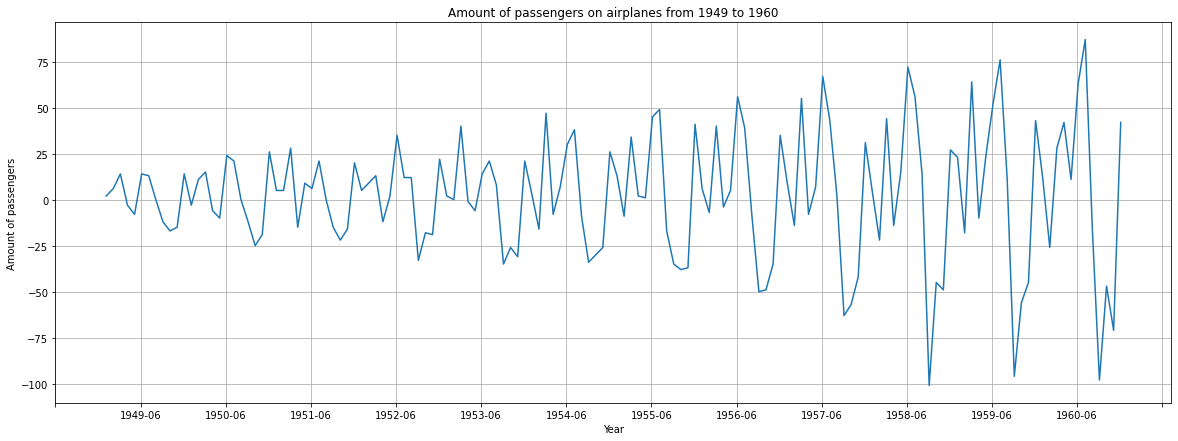

In [27]:
passengers_df["Untrended Passengers"] = passengers_df["Passengers"] - passengers_df["Passengers"].shift(1)
passengers_df["Untrended Passengers"][0] = int(passengers_df["Untrended Passengers"].mean())
# passengers_df["Untrended Passengers"]
fig, ax = plt.subplots(figsize=(20, 7))
# year_range = [float(str(x).split('-')[0]) for x in passengers_df['Untrended Passengers'] if pd.notna(x)]
year_range = []
for x in passengers_df['Untrended Passengers']:
    if pd.notna(x):
        year_range.append(int(x))
# print(year_range)
print(f"{min(year_range)} : {max(year_range)}")

ax.plot(passengers_df.Month, passengers_df['Untrended Passengers'])
ax.set_title("Amount of passengers on airplanes from 1949 to 1960")
ax.set_xlabel("Year")
ax.set_ylabel("Amount of passengers")
ax.grid(True)

start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 12))
plt.show()

I removed positive trend. k.

6. Split the data into training and test sets. Take the data from the very last year (1960) for the test set (i.e. the last 12 entries).  

In [30]:
test_12_last_months = passengers_df.iloc[132:]
train_the_rest = passengers_df.iloc[:132]

7. Create the index arrays for both train and test datasets. If you don’t remember how to do this from our ML class here is one example: train_idx = df.index <= train.index[-1], so just do the same for the test set.

In [34]:
test_ind_arr = passengers_df.index[132:]
train_ind_arr = passengers_df.index[:132]

8. Create the appropriate data structure for a time series analysis where the past 10 datapoints will be used to make predictions of the next 1 datapoint. 

In [ ]:
def create_dataset(data,past_gens):
    data_x, data_y = [], []
    for i in range(len(data) - past_gens - 1):
        a = data[i:(i+past_gens)]
        data_x.append(a)
        data_y.append(data[i+past_gens])
    return np.array(data_x), np.array(data_y)